# Question 2

In this question, we will determine the optimal batch size for mini-batch gradient descent. Find
the optimal batch size for mini-batch gradient descent by training the neural network and
evaluating the performances for different batch sizes. Note: Use 5-fold cross-validation on
training partition to perform hyperparameter selection.
You will have to reconsider the scaling of the dataset during the 5-fold cross validation.

In [1]:
import time

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import IPython.display as ipd

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
import tensorflow_docs as tfdocs
from tensorflow.keras import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint,LearningRateScheduler

2022-10-10 21:25:11.582715: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 21:25:11.582736: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [3]:
df = pd.read_csv('./data/full.csv')
pd.set_option('display.max_columns', None)
df.head()

,filename,tempo,total_beats,average_beats,chroma_stft_mean,chroma_stft_var,chroma_cq_mean,chroma_cq_var,chroma_cens_mean,chroma_cens_var,melspectrogram_mean,melspectrogram_var,mfcc_mean,mfcc_var,mfcc_delta_mean,mfcc_delta_var,rmse_mean,rmse_var,cent_mean,cent_var,spec_bw_mean,spec_bw_var,contrast_mean,contrast_var,rolloff_mean,rolloff_var,poly_mean,poly_var,tonnetz_mean,tonnetz_var,zcr_mean,zcr_var,harm_mean,harm_var,perc_mean,perc_var,frame_mean,frame_var,mfcc0_mean,mfcc0_var,mfcc1_mean,mfcc1_var,mfcc2_mean,mfcc2_var,mfcc3_mean,mfcc3_var,mfcc4_mean,mfcc4_var,mfcc5_mean,mfcc5_var,mfcc6_mean,mfcc6_var,mfcc7_mean,mfcc7_var,mfcc8_mean,mfcc8_var,mfcc9_mean,mfcc9_var,mfcc10_mean,mfcc10_var,mfcc11_mean,mfcc11_var,mfcc12_mean,mfcc12_var,mfcc13_mean,mfcc13_var,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var
0,app_3001_4001_phnd_neg_0000.wav,184.570312,623,69.222222,0.515281,0.093347,0.443441,0.082742,0.249143,0.021261,0.038422,0.087981,-16.290880,8822.263672,0.014360,7.908705,0.043470,0.000818,1833.579533,511344.031721,1746.559035,144881.971359,19.095815,319.628529,3827.147750,3827.147750,0.294635,0.294635,0.015770,0.012313,0.114622,0.004777,2.852700e-06,0.001529,7.470300e-06,0.000618,1.729204,0.945134,-389.578400,1394.284424,134.581345,694.736450,-39.877445,331.621368,55.018433,417.293945,-36.944489,246.965225,18.573177,270.046539,-19.398455,136.647842,4.641793,166.485138,-5.455597,105.498589,-6.548687,143.077621,1.620288,80.328003,-14.974999,55.536694,1.443957,105.002190,-10.213489,52.869869,0.718760,75.744896,-10.669799,63.340282,1.811605,58.117188,-3.286546,54.268448,-2.719069,59.548176,-4.559987,70.774803
1,app_3001_4001_phnd_neg_0001.wav,151.999081,521,74.428571,0.487201,0.094461,0.542182,0.073359,0.274423,0.008025,0.204988,5.152482,-16.183870,7335.709961,-0.025494,18.772476,0.090213,0.008415,1927.253538,354369.575716,1627.620214,68783.641466,19.186873,305.084512,3762.586531,3762.586531,0.583882,0.583882,0.015399,0.006057,0.122172,0.003331,-1.651200e-06,0.002638,-2.788160e-05,0.009359,1.793741,0.910349,-350.381317,5990.534668,112.355591,596.321411,-50.575706,1418.432983,39.114021,507.006927,-33.239597,416.781708,3.573578,236.576492,-11.785189,178.042618,-1.014654,178.834152,4.223846,226.874054,-8.432135,133.631943,-0.922831,75.745110,-14.040901,129.677872,-1.542051,89.679306,-2.871657,86.871460,-2.855503,106.239403,-5.666375,90.256195,1.573594,105.070496,-0.742024,82.417496,-1.961745,119.312355,1.513660,101.014572
2,app_3001_4001_phnd_neg_0002.wav,112.347147,1614,146.727273,0.444244,0.099268,0.442014,0.083224,0.264430,0.013410,0.218063,3.372185,-15.555374,7140.790039,-0.001268,10.850190,0.099754,0.005438,1558.350787,286662.686733,1480.320551,108552.760715,19.694916,271.168203,3027.938960,3027.938960,0.626042,0.626042,0.000772,0.012586,0.094763,0.002338,-2.344000e-07,0.005676,1.925600e-06,0.005432,2.204735,1.657315,-340.841705,2853.958740,139.396652,639.750854,-44.360332,786.586487,34.030853,405.441681,-37.146648,447.909576,1.166850,360.854797,-11.257973,170.027328,-3.371944,226.699600,1.764457,140.997101,-9.144030,123.745407,0.545947,68.511703,-12.346964,91.306229,-3.448010,96.648567,-4.782896,96.846092,-3.135671,85.535561,-5.502390,73.079750,0.202623,72.040550,-4.021009,73.844353,-5.916223,103.834824,-2.939086,113.598824
3,app_3001_4001_phnd_neg_0003.wav,107.666016,2060,158.461538,0.454156,0.100834,0.424370,0.084435,0.257672,0.016938,0.214154,3.943239,-16.382410,7671.897461,-0.017487,10.714126,0.092214,0.006496,1501.958914,236170.752891,1468.111222,100434.245015,19.731574,280.614702,2981.342123,2981.342123,0.544611,0.544611,0.024137,0.015121,0.085925,0.001861,-4.205000e-07,0.006873,-2.248000e-07,0.004422,1.789098,1.241672,-359.523376,3351.339844,135.395157,589.953613,-40.197311,840.564270,32.704830,312.519379,-28.228338,411.952454,0.862422,276.248840,-9.016964,178.003738,-6.123117,168.513107,1.593995,121.375755,-7.000763,103.869049,-3.3311

## a) Plot mean cross-validation accuracies on the final epoch for different batch sizes as a scatter plot. Limit search space to batch sizes {128, 256, 512, 1024}. This might take a while to run.

In [4]:
df['label'] = df['filename'].str.split('_').str[-2]

In [5]:
df['label'].value_counts()

pos    92826
neg    89428
Name: label, dtype: int64

Split and Scale data

In [6]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dropout

In [7]:
def get_callbacks():
  return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=100)

In [8]:
# callback to save the best weights for the model
def saveWeightsCallback(path,monitor,mode,save_freq):
    return tf.keras.callbacks.ModelCheckpoint(
        filepath=path,
        monitor = monitor,
        verbose = 0,
        save_best_only = True,
        save_weights_only = True,
        mode = mode,
        save_freq=save_freq,
)

In [9]:
class timecallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.last_time=0
        self.initial_time = time.time()
    def on_epoch_end(self,epoch,logs = {}):
        self.last_time = time.time() - self.initial_time

In [10]:
columns_to_drop = ['label','filename']

def split_dataset(df, columns_to_drop, test_size, random_state):
  label_encoder = preprocessing.LabelEncoder()

  df['label'] = label_encoder.fit_transform(df['label'])

  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop,axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop,axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):

  standard_scaler = preprocessing.StandardScaler()
  df_train_scaled = standard_scaler.fit_transform(df_train)

  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.3, random_state=0) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [11]:
# build the model
def build_model(input_shape, no_neurons_hidden):
    model = Sequential([
                InputLayer(input_shape),
                Dense(no_neurons_hidden,activation='relu'),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu'),
                Dropout(dropout_prob),
                Dense(no_neurons_hidden,activation='relu'),
                Dropout(dropout_prob),
                Dense(2,activation='softmax')
    ])
    return model

def compile_and_train(model,no_epochs,lr,batch_size,x_train,y_train,x_test,y_test,weight_path):
    
    model.compile(optimizer = Adam(learning_rate = lr), 
                loss='sparse_categorical_crossentropy',
                metrics=[
                'accuracy',
                'mean_squared_error'
             ])
            
    # use an instance to persist the callback data
    timecallbackinstance = timecallback()

    history = model.fit(x_train, y_train,
                        epochs=no_epochs,
                        batch_size = batch_size,
                        verbose=1,
                        callbacks= [get_callbacks(),
                                    timecallbackinstance,
                                   saveWeightsCallback(weight_path,
                                                       'val_loss',
                                                       'min',
                                                       'epoch')
                                   ],
                        use_multiprocessing=True,
                        validation_data=(x_test, y_test))
    return history,timecallbackinstance

### Training function:

In [12]:
no_folds = 5
total_data = X_train_scaled.shape[0]
no_epochs = 100
no_neurons_hidden = 128
lr = 0.001
dropout_prob = 0.2
batch_sizes = [128, 256, 512, 1024]



def train_exp(X, Y):
    
    err = []
    accuracy=[]
    last_epoch_times =[]
    histories = []
    
    
    for batch_size in batch_sizes:
        histories_ =[]
        accuracy_ =[]
        err_ = []
        last_epoch_times_ = []
    
        for fold in range(no_folds):
            
            start, end = fold*(total_data//5), (fold+1)*(total_data//5)

            x_test, y_test = X[start:end], Y[start:end]
            x_train  = np.append(X[:start], X[end:], axis=0)
            y_train = np.append(Y[:start], Y[end:], axis=0)

            # specify dir to save weights of best epochs for each fold for each batch size
            weight_path = './weights/PartA_Q2/{}_{}_fold_/best_epoch_weights'.format(batch_size,fold+1)
            
            model = build_model((x_train.shape[1],),no_neurons_hidden)
            history,timecallbackinstance = compile_and_train(model,
                                        no_epochs,
                                        lr,
                                        batch_size,
                                        x_train,
                                        y_train,
                                        x_test,
                                        y_test,
                                        weight_path)
        
            err_.append(min(history.history['val_loss']))
            accuracy_.append(history.history['val_accuracy'][-1])
            last_epoch_times_.append(timecallbackinstance.last_time)
            histories_.append(history)
    
        err.append(np.mean(err_))
        accuracy.append(np.mean(accuracy_))
        last_epoch_times.append(np.mean(last_epoch_times_))
        histories.append(histories_)
    
    return err,accuracy,last_epoch_times,histories

### Train model:

In [13]:
# perform experiments
err,accuracy,last_epoch_times,histories = train_exp(X_train_scaled,y_train)

Epoch 1/100


2022-10-10 21:25:52.367585: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-10-10 21:25:52.367913: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-10 21:25:52.367991: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2022-10-10 21:25:52.368058: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2022-10-10 21:25:52.371109: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

798/798 [==============================] - 2s 3ms/step - loss: 0.6908 - accuracy: 0.5366 - mean_squared_error: 0.2551 - val_loss: 0.6860 - val_accuracy: 0.5484 - val_mean_squared_error: 0.2520
Epoch 2/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6841 - accuracy: 0.5499 - mean_squared_error: 0.2551 - val_loss: 0.6823 - val_accuracy: 0.5536 - val_mean_squared_error: 0.2546
Epoch 3/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6821 - accuracy: 0.5563 - mean_squared_error: 0.2559 - val_loss: 0.6805 - val_accuracy: 0.5606 - val_mean_squared_error: 0.2574
Epoch 4/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6790 - accuracy: 0.5626 - mean_squared_error: 0.2573 - val_loss: 0.6786 - val_accuracy: 0.5628 - val_mean_squared_error: 0.2569
Epoch 5/100
798/798 [==============================] - 2s 2ms/step - loss: 0.6758 - accuracy: 0.5673 - mean_squared_error: 0.2588 - val_loss: 0.6760 - val_accuracy: 0.5709 - val_mean_squared_e

Epoch 41/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5949 - accuracy: 0.6686 - mean_squared_error: 0.2943 - val_loss: 0.6183 - val_accuracy: 0.6449 - val_mean_squared_error: 0.2782
Epoch 42/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5960 - accuracy: 0.6650 - mean_squared_error: 0.2937 - val_loss: 0.6175 - val_accuracy: 0.6462 - val_mean_squared_error: 0.2768
Epoch 43/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5942 - accuracy: 0.6691 - mean_squared_error: 0.2946 - val_loss: 0.6174 - val_accuracy: 0.6460 - val_mean_squared_error: 0.2778
Epoch 44/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5922 - accuracy: 0.6695 - mean_squared_error: 0.2953 - val_loss: 0.6176 - val_accuracy: 0.6459 - val_mean_squared_error: 0.2790
Epoch 45/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5901 - accuracy: 0.6719 - mean_squared_error: 0.2962 - val_loss: 0.6154 - val_accuracy: 0.6488 - v

Epoch 81/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5693 - accuracy: 0.6921 - mean_squared_error: 0.3053 - val_loss: 0.6033 - val_accuracy: 0.6632 - val_mean_squared_error: 0.2849
Epoch 82/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5690 - accuracy: 0.6921 - mean_squared_error: 0.3053 - val_loss: 0.6042 - val_accuracy: 0.6586 - val_mean_squared_error: 0.2827
Epoch 83/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5683 - accuracy: 0.6923 - mean_squared_error: 0.3054 - val_loss: 0.6031 - val_accuracy: 0.6634 - val_mean_squared_error: 0.2884
Epoch 84/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5682 - accuracy: 0.6921 - mean_squared_error: 0.3054 - val_loss: 0.6034 - val_accuracy: 0.6616 - val_mean_squared_error: 0.2866
Epoch 85/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5674 - accuracy: 0.6925 - mean_squared_error: 0.3059 - val_loss: 0.6018 - val_accuracy: 0.6626 - v

Epoch 21/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6266 - accuracy: 0.6327 - mean_squared_error: 0.2808 - val_loss: 0.6375 - val_accuracy: 0.6264 - val_mean_squared_error: 0.2675
Epoch 22/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6233 - accuracy: 0.6387 - mean_squared_error: 0.2821 - val_loss: 0.6375 - val_accuracy: 0.6229 - val_mean_squared_error: 0.2703
Epoch 23/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6200 - accuracy: 0.6414 - mean_squared_error: 0.2836 - val_loss: 0.6342 - val_accuracy: 0.6281 - val_mean_squared_error: 0.2705
Epoch 24/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6193 - accuracy: 0.6428 - mean_squared_error: 0.2839 - val_loss: 0.6330 - val_accuracy: 0.6270 - val_mean_squared_error: 0.2715
Epoch 25/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6171 - accuracy: 0.6437 - mean_squared_error: 0.2847 - val_loss: 0.6338 - val_accuracy: 0.6291 - v

Epoch 61/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5790 - accuracy: 0.6824 - mean_squared_error: 0.3010 - val_loss: 0.6069 - val_accuracy: 0.6586 - val_mean_squared_error: 0.2816
Epoch 62/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5781 - accuracy: 0.6815 - mean_squared_error: 0.3012 - val_loss: 0.6054 - val_accuracy: 0.6609 - val_mean_squared_error: 0.2841
Epoch 63/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5783 - accuracy: 0.6826 - mean_squared_error: 0.3013 - val_loss: 0.6082 - val_accuracy: 0.6578 - val_mean_squared_error: 0.2812
Epoch 64/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5767 - accuracy: 0.6840 - mean_squared_error: 0.3020 - val_loss: 0.6053 - val_accuracy: 0.6611 - val_mean_squared_error: 0.2831
Epoch 65/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5771 - accuracy: 0.6836 - mean_squared_error: 0.3018 - val_loss: 0.6040 - val_accuracy: 0.6599 - v

Epoch 1/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6922 - accuracy: 0.5334 - mean_squared_error: 0.2554 - val_loss: 0.6836 - val_accuracy: 0.5509 - val_mean_squared_error: 0.2525
Epoch 2/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6844 - accuracy: 0.5503 - mean_squared_error: 0.2551 - val_loss: 0.6814 - val_accuracy: 0.5569 - val_mean_squared_error: 0.2535
Epoch 3/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6817 - accuracy: 0.5558 - mean_squared_error: 0.2561 - val_loss: 0.6790 - val_accuracy: 0.5613 - val_mean_squared_error: 0.2559
Epoch 4/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6788 - accuracy: 0.5611 - mean_squared_error: 0.2573 - val_loss: 0.6768 - val_accuracy: 0.5725 - val_mean_squared_error: 0.2566
Epoch 5/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6763 - accuracy: 0.5672 - mean_squared_error: 0.2586 - val_loss: 0.6752 - val_accuracy: 0.5714 - val_me

Epoch 41/100
798/798 [==============================] - 3s 4ms/step - loss: 0.5961 - accuracy: 0.6639 - mean_squared_error: 0.2939 - val_loss: 0.6191 - val_accuracy: 0.6486 - val_mean_squared_error: 0.2759
Epoch 42/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5945 - accuracy: 0.6682 - mean_squared_error: 0.2944 - val_loss: 0.6179 - val_accuracy: 0.6452 - val_mean_squared_error: 0.2782
Epoch 43/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5928 - accuracy: 0.6689 - mean_squared_error: 0.2952 - val_loss: 0.6179 - val_accuracy: 0.6455 - val_mean_squared_error: 0.2774
Epoch 44/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5924 - accuracy: 0.6694 - mean_squared_error: 0.2952 - val_loss: 0.6162 - val_accuracy: 0.6523 - val_mean_squared_error: 0.2786
Epoch 45/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5924 - accuracy: 0.6688 - mean_squared_error: 0.2954 - val_loss: 0.6152 - val_accuracy: 0.6533 - v

Epoch 81/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5695 - accuracy: 0.6900 - mean_squared_error: 0.3050 - val_loss: 0.6061 - val_accuracy: 0.6594 - val_mean_squared_error: 0.2832
Epoch 82/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5688 - accuracy: 0.6904 - mean_squared_error: 0.3052 - val_loss: 0.6043 - val_accuracy: 0.6611 - val_mean_squared_error: 0.2841
Epoch 83/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5694 - accuracy: 0.6910 - mean_squared_error: 0.3051 - val_loss: 0.6024 - val_accuracy: 0.6623 - val_mean_squared_error: 0.2854
Epoch 84/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5669 - accuracy: 0.6924 - mean_squared_error: 0.3060 - val_loss: 0.6018 - val_accuracy: 0.6645 - val_mean_squared_error: 0.2849
Epoch 85/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5690 - accuracy: 0.6882 - mean_squared_error: 0.3051 - val_loss: 0.6033 - val_accuracy: 0.6622 - v

Epoch 21/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6225 - accuracy: 0.6419 - mean_squared_error: 0.2827 - val_loss: 0.6371 - val_accuracy: 0.6278 - val_mean_squared_error: 0.2702
Epoch 22/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6211 - accuracy: 0.6450 - mean_squared_error: 0.2834 - val_loss: 0.6350 - val_accuracy: 0.6317 - val_mean_squared_error: 0.2717
Epoch 23/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6187 - accuracy: 0.6475 - mean_squared_error: 0.2844 - val_loss: 0.6334 - val_accuracy: 0.6326 - val_mean_squared_error: 0.2714
Epoch 24/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6163 - accuracy: 0.6493 - mean_squared_error: 0.2854 - val_loss: 0.6337 - val_accuracy: 0.6305 - val_mean_squared_error: 0.2713
Epoch 25/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6148 - accuracy: 0.6498 - mean_squared_error: 0.2859 - val_loss: 0.6303 - val_accuracy: 0.6337 - v

Epoch 61/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5756 - accuracy: 0.6866 - mean_squared_error: 0.3029 - val_loss: 0.6081 - val_accuracy: 0.6607 - val_mean_squared_error: 0.2814
Epoch 62/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5761 - accuracy: 0.6861 - mean_squared_error: 0.3024 - val_loss: 0.6073 - val_accuracy: 0.6597 - val_mean_squared_error: 0.2833
Epoch 63/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5747 - accuracy: 0.6879 - mean_squared_error: 0.3029 - val_loss: 0.6051 - val_accuracy: 0.6582 - val_mean_squared_error: 0.2877
Epoch 64/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5735 - accuracy: 0.6872 - mean_squared_error: 0.3035 - val_loss: 0.6054 - val_accuracy: 0.6603 - val_mean_squared_error: 0.2870
Epoch 65/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5733 - accuracy: 0.6895 - mean_squared_error: 0.3037 - val_loss: 0.6060 - val_accuracy: 0.6597 - v

Epoch 1/100
798/798 [==============================] - 3s 3ms/step - loss: 0.6917 - accuracy: 0.5327 - mean_squared_error: 0.2551 - val_loss: 0.6843 - val_accuracy: 0.5504 - val_mean_squared_error: 0.2532
Epoch 2/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6843 - accuracy: 0.5494 - mean_squared_error: 0.2551 - val_loss: 0.6829 - val_accuracy: 0.5579 - val_mean_squared_error: 0.2523
Epoch 3/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6817 - accuracy: 0.5560 - mean_squared_error: 0.2560 - val_loss: 0.6798 - val_accuracy: 0.5608 - val_mean_squared_error: 0.2558
Epoch 4/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6799 - accuracy: 0.5593 - mean_squared_error: 0.2569 - val_loss: 0.6775 - val_accuracy: 0.5692 - val_mean_squared_error: 0.2559
Epoch 5/100
798/798 [==============================] - 2s 3ms/step - loss: 0.6766 - accuracy: 0.5675 - mean_squared_error: 0.2584 - val_loss: 0.6764 - val_accuracy: 0.5716 - val_me

Epoch 41/100
798/798 [==============================] - 4s 5ms/step - loss: 0.5977 - accuracy: 0.6654 - mean_squared_error: 0.2935 - val_loss: 0.6197 - val_accuracy: 0.6448 - val_mean_squared_error: 0.2765
Epoch 42/100
798/798 [==============================] - 4s 5ms/step - loss: 0.5963 - accuracy: 0.6677 - mean_squared_error: 0.2938 - val_loss: 0.6184 - val_accuracy: 0.6483 - val_mean_squared_error: 0.2776
Epoch 43/100
798/798 [==============================] - 3s 4ms/step - loss: 0.5950 - accuracy: 0.6704 - mean_squared_error: 0.2945 - val_loss: 0.6163 - val_accuracy: 0.6508 - val_mean_squared_error: 0.2800
Epoch 44/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5938 - accuracy: 0.6682 - mean_squared_error: 0.2947 - val_loss: 0.6150 - val_accuracy: 0.6513 - val_mean_squared_error: 0.2791
Epoch 45/100
798/798 [==============================] - 3s 3ms/step - loss: 0.5933 - accuracy: 0.6684 - mean_squared_error: 0.2953 - val_loss: 0.6167 - val_accuracy: 0.6500 - v

Epoch 81/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5723 - accuracy: 0.6888 - mean_squared_error: 0.3039 - val_loss: 0.6031 - val_accuracy: 0.6629 - val_mean_squared_error: 0.2871
Epoch 82/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5711 - accuracy: 0.6900 - mean_squared_error: 0.3046 - val_loss: 0.6026 - val_accuracy: 0.6623 - val_mean_squared_error: 0.2850
Epoch 83/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5695 - accuracy: 0.6920 - mean_squared_error: 0.3052 - val_loss: 0.6012 - val_accuracy: 0.6655 - val_mean_squared_error: 0.2847
Epoch 84/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5702 - accuracy: 0.6924 - mean_squared_error: 0.3050 - val_loss: 0.6028 - val_accuracy: 0.6642 - val_mean_squared_error: 0.2825
Epoch 85/100
798/798 [==============================] - 2s 3ms/step - loss: 0.5707 - accuracy: 0.6911 - mean_squared_error: 0.3048 - val_loss: 0.6029 - val_accuracy: 0.6603 - v

Epoch 21/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6296 - accuracy: 0.6334 - mean_squared_error: 0.2794 - val_loss: 0.6408 - val_accuracy: 0.6245 - val_mean_squared_error: 0.2670
Epoch 22/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6264 - accuracy: 0.6371 - mean_squared_error: 0.2807 - val_loss: 0.6377 - val_accuracy: 0.6244 - val_mean_squared_error: 0.2689
Epoch 23/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6243 - accuracy: 0.6390 - mean_squared_error: 0.2816 - val_loss: 0.6376 - val_accuracy: 0.6233 - val_mean_squared_error: 0.2687
Epoch 24/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6224 - accuracy: 0.6421 - mean_squared_error: 0.2824 - val_loss: 0.6358 - val_accuracy: 0.6260 - val_mean_squared_error: 0.2716
Epoch 25/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6217 - accuracy: 0.6420 - mean_squared_error: 0.2828 - val_loss: 0.6330 - val_accuracy: 0.6301 - v

Epoch 61/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5806 - accuracy: 0.6839 - mean_squared_error: 0.3003 - val_loss: 0.6096 - val_accuracy: 0.6549 - val_mean_squared_error: 0.2828
Epoch 62/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5792 - accuracy: 0.6833 - mean_squared_error: 0.3008 - val_loss: 0.6057 - val_accuracy: 0.6560 - val_mean_squared_error: 0.2829
Epoch 63/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5794 - accuracy: 0.6820 - mean_squared_error: 0.3005 - val_loss: 0.6069 - val_accuracy: 0.6556 - val_mean_squared_error: 0.2835
Epoch 64/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5791 - accuracy: 0.6837 - mean_squared_error: 0.3011 - val_loss: 0.6065 - val_accuracy: 0.6585 - val_mean_squared_error: 0.2855
Epoch 65/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5779 - accuracy: 0.6848 - mean_squared_error: 0.3013 - val_loss: 0.6039 - val_accuracy: 0.6575 - v

Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6922 - accuracy: 0.5326 - mean_squared_error: 0.2552 - val_loss: 0.6850 - val_accuracy: 0.5522 - val_mean_squared_error: 0.2517
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6847 - accuracy: 0.5494 - mean_squared_error: 0.2547 - val_loss: 0.6817 - val_accuracy: 0.5555 - val_mean_squared_error: 0.2535
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6826 - accuracy: 0.5544 - mean_squared_error: 0.2557 - val_loss: 0.6792 - val_accuracy: 0.5597 - val_mean_squared_error: 0.2552
Epoch 4/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6802 - accuracy: 0.5608 - mean_squared_error: 0.2567 - val_loss: 0.6785 - val_accuracy: 0.5601 - val_mean_squared_error: 0.2573
Epoch 5/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6780 - accuracy: 0.5665 - mean_squared_error: 0.2576 - val_loss: 0.6763 - val_accuracy: 0.5647 - val_me

Epoch 41/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5980 - accuracy: 0.6667 - mean_squared_error: 0.2928 - val_loss: 0.6210 - val_accuracy: 0.6425 - val_mean_squared_error: 0.2783
Epoch 42/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5988 - accuracy: 0.6645 - mean_squared_error: 0.2929 - val_loss: 0.6205 - val_accuracy: 0.6456 - val_mean_squared_error: 0.2754
Epoch 43/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5984 - accuracy: 0.6657 - mean_squared_error: 0.2926 - val_loss: 0.6182 - val_accuracy: 0.6429 - val_mean_squared_error: 0.2765
Epoch 44/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5954 - accuracy: 0.6689 - mean_squared_error: 0.2940 - val_loss: 0.6191 - val_accuracy: 0.6453 - val_mean_squared_error: 0.2774
Epoch 45/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5964 - accuracy: 0.6706 - mean_squared_error: 0.2940 - val_loss: 0.6188 - val_accuracy: 0.6432 - v

Epoch 81/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5717 - accuracy: 0.6910 - mean_squared_error: 0.3041 - val_loss: 0.6029 - val_accuracy: 0.6621 - val_mean_squared_error: 0.2848
Epoch 82/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5714 - accuracy: 0.6908 - mean_squared_error: 0.3042 - val_loss: 0.6024 - val_accuracy: 0.6596 - val_mean_squared_error: 0.2833
Epoch 83/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5712 - accuracy: 0.6908 - mean_squared_error: 0.3041 - val_loss: 0.6031 - val_accuracy: 0.6588 - val_mean_squared_error: 0.2851
Epoch 84/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5703 - accuracy: 0.6920 - mean_squared_error: 0.3047 - val_loss: 0.6021 - val_accuracy: 0.6597 - val_mean_squared_error: 0.2816
Epoch 85/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5699 - accuracy: 0.6915 - mean_squared_error: 0.3048 - val_loss: 0.6028 - val_accuracy: 0.6627 - v

Epoch 21/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6289 - accuracy: 0.6354 - mean_squared_error: 0.2795 - val_loss: 0.6376 - val_accuracy: 0.6267 - val_mean_squared_error: 0.2680
Epoch 22/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6270 - accuracy: 0.6352 - mean_squared_error: 0.2805 - val_loss: 0.6386 - val_accuracy: 0.6210 - val_mean_squared_error: 0.2692
Epoch 23/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6242 - accuracy: 0.6398 - mean_squared_error: 0.2816 - val_loss: 0.6347 - val_accuracy: 0.6296 - val_mean_squared_error: 0.2712
Epoch 24/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6220 - accuracy: 0.6428 - mean_squared_error: 0.2826 - val_loss: 0.6339 - val_accuracy: 0.6284 - val_mean_squared_error: 0.2722
Epoch 25/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6208 - accuracy: 0.6431 - mean_squared_error: 0.2831 - val_loss: 0.6328 - val_accuracy: 0.6312 - v

Epoch 61/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5821 - accuracy: 0.6804 - mean_squared_error: 0.2997 - val_loss: 0.6072 - val_accuracy: 0.6557 - val_mean_squared_error: 0.2811
Epoch 62/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5811 - accuracy: 0.6817 - mean_squared_error: 0.3000 - val_loss: 0.6073 - val_accuracy: 0.6550 - val_mean_squared_error: 0.2820
Epoch 63/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5809 - accuracy: 0.6816 - mean_squared_error: 0.3001 - val_loss: 0.6085 - val_accuracy: 0.6574 - val_mean_squared_error: 0.2804
Epoch 64/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5798 - accuracy: 0.6825 - mean_squared_error: 0.3005 - val_loss: 0.6066 - val_accuracy: 0.6592 - val_mean_squared_error: 0.2820
Epoch 65/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5784 - accuracy: 0.6829 - mean_squared_error: 0.3011 - val_loss: 0.6077 - val_accuracy: 0.6573 - v

Epoch 1/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6936 - accuracy: 0.5331 - mean_squared_error: 0.2556 - val_loss: 0.6848 - val_accuracy: 0.5529 - val_mean_squared_error: 0.2521
Epoch 2/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6842 - accuracy: 0.5501 - mean_squared_error: 0.2553 - val_loss: 0.6823 - val_accuracy: 0.5561 - val_mean_squared_error: 0.2529
Epoch 3/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6814 - accuracy: 0.5565 - mean_squared_error: 0.2562 - val_loss: 0.6805 - val_accuracy: 0.5591 - val_mean_squared_error: 0.2539
Epoch 4/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6790 - accuracy: 0.5638 - mean_squared_error: 0.2573 - val_loss: 0.6778 - val_accuracy: 0.5639 - val_mean_squared_error: 0.2556
Epoch 5/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6761 - accuracy: 0.5695 - mean_squared_error: 0.2585 - val_loss: 0.6759 - val_accuracy: 0.5731 - val_me

Epoch 41/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5973 - accuracy: 0.6659 - mean_squared_error: 0.2935 - val_loss: 0.6220 - val_accuracy: 0.6459 - val_mean_squared_error: 0.2764
Epoch 42/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5955 - accuracy: 0.6677 - mean_squared_error: 0.2940 - val_loss: 0.6238 - val_accuracy: 0.6410 - val_mean_squared_error: 0.2766
Epoch 43/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5947 - accuracy: 0.6673 - mean_squared_error: 0.2942 - val_loss: 0.6219 - val_accuracy: 0.6446 - val_mean_squared_error: 0.2781
Epoch 44/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5927 - accuracy: 0.6694 - mean_squared_error: 0.2950 - val_loss: 0.6229 - val_accuracy: 0.6429 - val_mean_squared_error: 0.2773
Epoch 45/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5930 - accuracy: 0.6690 - mean_squared_error: 0.2952 - val_loss: 0.6215 - val_accuracy: 0.6426 - v

Epoch 81/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5703 - accuracy: 0.6890 - mean_squared_error: 0.3047 - val_loss: 0.6106 - val_accuracy: 0.6564 - val_mean_squared_error: 0.2822
Epoch 82/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5686 - accuracy: 0.6919 - mean_squared_error: 0.3050 - val_loss: 0.6083 - val_accuracy: 0.6568 - val_mean_squared_error: 0.2836
Epoch 83/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5691 - accuracy: 0.6907 - mean_squared_error: 0.3049 - val_loss: 0.6069 - val_accuracy: 0.6560 - val_mean_squared_error: 0.2840
Epoch 84/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5688 - accuracy: 0.6905 - mean_squared_error: 0.3051 - val_loss: 0.6083 - val_accuracy: 0.6592 - val_mean_squared_error: 0.2821
Epoch 85/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5680 - accuracy: 0.6930 - mean_squared_error: 0.3053 - val_loss: 0.6054 - val_accuracy: 0.6603 - v

Epoch 21/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6314 - accuracy: 0.6315 - mean_squared_error: 0.2786 - val_loss: 0.6410 - val_accuracy: 0.6219 - val_mean_squared_error: 0.2697
Epoch 22/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6279 - accuracy: 0.6338 - mean_squared_error: 0.2799 - val_loss: 0.6404 - val_accuracy: 0.6272 - val_mean_squared_error: 0.2697
Epoch 23/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6256 - accuracy: 0.6368 - mean_squared_error: 0.2811 - val_loss: 0.6381 - val_accuracy: 0.6233 - val_mean_squared_error: 0.2696
Epoch 24/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6242 - accuracy: 0.6395 - mean_squared_error: 0.2815 - val_loss: 0.6376 - val_accuracy: 0.6263 - val_mean_squared_error: 0.2717
Epoch 25/100
399/399 [==============================] - 2s 4ms/step - loss: 0.6212 - accuracy: 0.6411 - mean_squared_error: 0.2828 - val_loss: 0.6359 - val_accuracy: 0.6279 - v

Epoch 61/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5798 - accuracy: 0.6811 - mean_squared_error: 0.3001 - val_loss: 0.6083 - val_accuracy: 0.6585 - val_mean_squared_error: 0.2830
Epoch 62/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5829 - accuracy: 0.6807 - mean_squared_error: 0.2992 - val_loss: 0.6080 - val_accuracy: 0.6611 - val_mean_squared_error: 0.2825
Epoch 63/100
399/399 [==============================] - 2s 4ms/step - loss: 0.5816 - accuracy: 0.6791 - mean_squared_error: 0.2997 - val_loss: 0.6096 - val_accuracy: 0.6570 - val_mean_squared_error: 0.2830
Epoch 64/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5789 - accuracy: 0.6826 - mean_squared_error: 0.3010 - val_loss: 0.6087 - val_accuracy: 0.6573 - val_mean_squared_error: 0.2839
Epoch 65/100
399/399 [==============================] - 2s 5ms/step - loss: 0.5796 - accuracy: 0.6813 - mean_squared_error: 0.3006 - val_loss: 0.6081 - val_accuracy: 0.6581 - v

Epoch 1/100
200/200 [==============================] - 2s 7ms/step - loss: 0.6938 - accuracy: 0.5299 - mean_squared_error: 0.2558 - val_loss: 0.6859 - val_accuracy: 0.5460 - val_mean_squared_error: 0.2523
Epoch 2/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6852 - accuracy: 0.5469 - mean_squared_error: 0.2549 - val_loss: 0.6828 - val_accuracy: 0.5523 - val_mean_squared_error: 0.2549
Epoch 3/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6828 - accuracy: 0.5537 - mean_squared_error: 0.2557 - val_loss: 0.6810 - val_accuracy: 0.5602 - val_mean_squared_error: 0.2555
Epoch 4/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6799 - accuracy: 0.5608 - mean_squared_error: 0.2567 - val_loss: 0.6798 - val_accuracy: 0.5621 - val_mean_squared_error: 0.2557
Epoch 5/100
200/200 [==============================] - 1s 6ms/step - loss: 0.6784 - accuracy: 0.5650 - mean_squared_error: 0.2573 - val_loss: 0.6778 - val_accuracy: 0.5688 - val_me

Epoch 41/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6037 - accuracy: 0.6627 - mean_squared_error: 0.2904 - val_loss: 0.6247 - val_accuracy: 0.6442 - val_mean_squared_error: 0.2767
Epoch 42/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6023 - accuracy: 0.6636 - mean_squared_error: 0.2911 - val_loss: 0.6240 - val_accuracy: 0.6430 - val_mean_squared_error: 0.2738
Epoch 43/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6004 - accuracy: 0.6637 - mean_squared_error: 0.2915 - val_loss: 0.6230 - val_accuracy: 0.6446 - val_mean_squared_error: 0.2759
Epoch 44/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5999 - accuracy: 0.6659 - mean_squared_error: 0.2918 - val_loss: 0.6216 - val_accuracy: 0.6474 - val_mean_squared_error: 0.2758
Epoch 45/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5983 - accuracy: 0.6660 - mean_squared_error: 0.2927 - val_loss: 0.6218 - val_accuracy: 0.6481 - v

Epoch 81/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5758 - accuracy: 0.6880 - mean_squared_error: 0.3025 - val_loss: 0.6060 - val_accuracy: 0.6624 - val_mean_squared_error: 0.2835
Epoch 82/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5754 - accuracy: 0.6893 - mean_squared_error: 0.3021 - val_loss: 0.6065 - val_accuracy: 0.6617 - val_mean_squared_error: 0.2832
Epoch 83/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.6898 - mean_squared_error: 0.3035 - val_loss: 0.6059 - val_accuracy: 0.6615 - val_mean_squared_error: 0.2846
Epoch 84/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.6908 - mean_squared_error: 0.3037 - val_loss: 0.6052 - val_accuracy: 0.6617 - val_mean_squared_error: 0.2833
Epoch 85/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5723 - accuracy: 0.6899 - mean_squared_error: 0.3035 - val_loss: 0.6040 - val_accuracy: 0.6634 - v

Epoch 21/100
200/200 [==============================] - 2s 8ms/step - loss: 0.6344 - accuracy: 0.6285 - mean_squared_error: 0.2770 - val_loss: 0.6430 - val_accuracy: 0.6208 - val_mean_squared_error: 0.2667
Epoch 22/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6331 - accuracy: 0.6305 - mean_squared_error: 0.2777 - val_loss: 0.6444 - val_accuracy: 0.6201 - val_mean_squared_error: 0.2656
Epoch 23/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6312 - accuracy: 0.6327 - mean_squared_error: 0.2784 - val_loss: 0.6416 - val_accuracy: 0.6195 - val_mean_squared_error: 0.2677
Epoch 24/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6279 - accuracy: 0.6340 - mean_squared_error: 0.2796 - val_loss: 0.6396 - val_accuracy: 0.6222 - val_mean_squared_error: 0.2704
Epoch 25/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6272 - accuracy: 0.6353 - mean_squared_error: 0.2802 - val_loss: 0.6374 - val_accuracy: 0.6278 - v

Epoch 61/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5852 - accuracy: 0.6785 - mean_squared_error: 0.2983 - val_loss: 0.6084 - val_accuracy: 0.6583 - val_mean_squared_error: 0.2808
Epoch 62/100
200/200 [==============================] - 2s 8ms/step - loss: 0.5826 - accuracy: 0.6804 - mean_squared_error: 0.2991 - val_loss: 0.6078 - val_accuracy: 0.6585 - val_mean_squared_error: 0.2821
Epoch 63/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5829 - accuracy: 0.6816 - mean_squared_error: 0.2992 - val_loss: 0.6085 - val_accuracy: 0.6581 - val_mean_squared_error: 0.2801
Epoch 64/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5810 - accuracy: 0.6820 - mean_squared_error: 0.2998 - val_loss: 0.6070 - val_accuracy: 0.6600 - val_mean_squared_error: 0.2820
Epoch 65/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5809 - accuracy: 0.6831 - mean_squared_error: 0.3002 - val_loss: 0.6076 - val_accuracy: 0.6575 - v

Epoch 1/100
200/200 [==============================] - 2s 8ms/step - loss: 0.6955 - accuracy: 0.5318 - mean_squared_error: 0.2563 - val_loss: 0.6845 - val_accuracy: 0.5506 - val_mean_squared_error: 0.2523
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6854 - accuracy: 0.5472 - mean_squared_error: 0.2550 - val_loss: 0.6815 - val_accuracy: 0.5574 - val_mean_squared_error: 0.2536
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6828 - accuracy: 0.5536 - mean_squared_error: 0.2556 - val_loss: 0.6793 - val_accuracy: 0.5655 - val_mean_squared_error: 0.2538
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6807 - accuracy: 0.5612 - mean_squared_error: 0.2565 - val_loss: 0.6786 - val_accuracy: 0.5648 - val_mean_squared_error: 0.2546
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6784 - accuracy: 0.5658 - mean_squared_error: 0.2574 - val_loss: 0.6772 - val_accuracy: 0.5706 - val_me

Epoch 41/100
200/200 [==============================] - 2s 8ms/step - loss: 0.6005 - accuracy: 0.6642 - mean_squared_error: 0.2919 - val_loss: 0.6213 - val_accuracy: 0.6455 - val_mean_squared_error: 0.2763
Epoch 42/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6017 - accuracy: 0.6627 - mean_squared_error: 0.2915 - val_loss: 0.6224 - val_accuracy: 0.6471 - val_mean_squared_error: 0.2751
Epoch 43/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5992 - accuracy: 0.6667 - mean_squared_error: 0.2923 - val_loss: 0.6193 - val_accuracy: 0.6471 - val_mean_squared_error: 0.2753
Epoch 44/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5972 - accuracy: 0.6684 - mean_squared_error: 0.2929 - val_loss: 0.6179 - val_accuracy: 0.6479 - val_mean_squared_error: 0.2776
Epoch 45/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5969 - accuracy: 0.6694 - mean_squared_error: 0.2934 - val_loss: 0.6182 - val_accuracy: 0.6495 - v

Epoch 81/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5719 - accuracy: 0.6920 - mean_squared_error: 0.3040 - val_loss: 0.6060 - val_accuracy: 0.6579 - val_mean_squared_error: 0.2835
Epoch 82/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5721 - accuracy: 0.6914 - mean_squared_error: 0.3039 - val_loss: 0.6050 - val_accuracy: 0.6617 - val_mean_squared_error: 0.2835
Epoch 83/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5724 - accuracy: 0.6891 - mean_squared_error: 0.3037 - val_loss: 0.6062 - val_accuracy: 0.6620 - val_mean_squared_error: 0.2830
Epoch 84/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5697 - accuracy: 0.6937 - mean_squared_error: 0.3045 - val_loss: 0.6072 - val_accuracy: 0.6578 - val_mean_squared_error: 0.2838
Epoch 85/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5714 - accuracy: 0.6908 - mean_squared_error: 0.3044 - val_loss: 0.6047 - val_accuracy: 0.6635 - v

Epoch 21/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6336 - accuracy: 0.6316 - mean_squared_error: 0.2775 - val_loss: 0.6452 - val_accuracy: 0.6154 - val_mean_squared_error: 0.2678
Epoch 22/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6304 - accuracy: 0.6336 - mean_squared_error: 0.2788 - val_loss: 0.6448 - val_accuracy: 0.6164 - val_mean_squared_error: 0.2683
Epoch 23/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6288 - accuracy: 0.6375 - mean_squared_error: 0.2797 - val_loss: 0.6422 - val_accuracy: 0.6172 - val_mean_squared_error: 0.2697
Epoch 24/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6266 - accuracy: 0.6381 - mean_squared_error: 0.2805 - val_loss: 0.6426 - val_accuracy: 0.6194 - val_mean_squared_error: 0.2698
Epoch 25/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6247 - accuracy: 0.6418 - mean_squared_error: 0.2816 - val_loss: 0.6400 - val_accuracy: 0.6225 - v

Epoch 61/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5821 - accuracy: 0.6830 - mean_squared_error: 0.2995 - val_loss: 0.6117 - val_accuracy: 0.6509 - val_mean_squared_error: 0.2821
Epoch 62/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5831 - accuracy: 0.6814 - mean_squared_error: 0.2995 - val_loss: 0.6116 - val_accuracy: 0.6518 - val_mean_squared_error: 0.2804
Epoch 63/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5811 - accuracy: 0.6838 - mean_squared_error: 0.2997 - val_loss: 0.6108 - val_accuracy: 0.6534 - val_mean_squared_error: 0.2825
Epoch 64/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5808 - accuracy: 0.6844 - mean_squared_error: 0.3004 - val_loss: 0.6112 - val_accuracy: 0.6520 - val_mean_squared_error: 0.2824
Epoch 65/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5805 - accuracy: 0.6844 - mean_squared_error: 0.3003 - val_loss: 0.6096 - val_accuracy: 0.6523 - v

Epoch 1/100
200/200 [==============================] - 2s 7ms/step - loss: 0.6953 - accuracy: 0.5261 - mean_squared_error: 0.2556 - val_loss: 0.6863 - val_accuracy: 0.5451 - val_mean_squared_error: 0.2522
Epoch 2/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6865 - accuracy: 0.5452 - mean_squared_error: 0.2545 - val_loss: 0.6842 - val_accuracy: 0.5505 - val_mean_squared_error: 0.2521
Epoch 3/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6835 - accuracy: 0.5514 - mean_squared_error: 0.2552 - val_loss: 0.6816 - val_accuracy: 0.5561 - val_mean_squared_error: 0.2535
Epoch 4/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6816 - accuracy: 0.5561 - mean_squared_error: 0.2559 - val_loss: 0.6788 - val_accuracy: 0.5634 - val_mean_squared_error: 0.2551
Epoch 5/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6793 - accuracy: 0.5635 - mean_squared_error: 0.2570 - val_loss: 0.6794 - val_accuracy: 0.5654 - val_me

Epoch 41/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6030 - accuracy: 0.6637 - mean_squared_error: 0.2908 - val_loss: 0.6187 - val_accuracy: 0.6494 - val_mean_squared_error: 0.2770
Epoch 42/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6016 - accuracy: 0.6631 - mean_squared_error: 0.2914 - val_loss: 0.6190 - val_accuracy: 0.6493 - val_mean_squared_error: 0.2764
Epoch 43/100
200/200 [==============================] - 1s 7ms/step - loss: 0.6008 - accuracy: 0.6640 - mean_squared_error: 0.2914 - val_loss: 0.6170 - val_accuracy: 0.6498 - val_mean_squared_error: 0.2782
Epoch 44/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5992 - accuracy: 0.6676 - mean_squared_error: 0.2926 - val_loss: 0.6158 - val_accuracy: 0.6508 - val_mean_squared_error: 0.2785
Epoch 45/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5975 - accuracy: 0.6684 - mean_squared_error: 0.2928 - val_loss: 0.6173 - val_accuracy: 0.6496 - v

Epoch 81/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5735 - accuracy: 0.6907 - mean_squared_error: 0.3032 - val_loss: 0.6037 - val_accuracy: 0.6615 - val_mean_squared_error: 0.2853
Epoch 82/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5739 - accuracy: 0.6885 - mean_squared_error: 0.3028 - val_loss: 0.6037 - val_accuracy: 0.6615 - val_mean_squared_error: 0.2854
Epoch 83/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5715 - accuracy: 0.6917 - mean_squared_error: 0.3039 - val_loss: 0.6031 - val_accuracy: 0.6620 - val_mean_squared_error: 0.2862
Epoch 84/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5730 - accuracy: 0.6900 - mean_squared_error: 0.3038 - val_loss: 0.6023 - val_accuracy: 0.6608 - val_mean_squared_error: 0.2853
Epoch 85/100
200/200 [==============================] - 1s 7ms/step - loss: 0.5718 - accuracy: 0.6915 - mean_squared_error: 0.3039 - val_loss: 0.6040 - val_accuracy: 0.6642 - v

Epoch 21/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6450 - accuracy: 0.6178 - mean_squared_error: 0.2720 - val_loss: 0.6526 - val_accuracy: 0.6052 - val_mean_squared_error: 0.2639
Epoch 22/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6438 - accuracy: 0.6181 - mean_squared_error: 0.2731 - val_loss: 0.6517 - val_accuracy: 0.6096 - val_mean_squared_error: 0.2638
Epoch 23/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6415 - accuracy: 0.6207 - mean_squared_error: 0.2736 - val_loss: 0.6500 - val_accuracy: 0.6096 - val_mean_squared_error: 0.2652
Epoch 24/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6394 - accuracy: 0.6228 - mean_squared_error: 0.2745 - val_loss: 0.6474 - val_accuracy: 0.6153 - val_mean_squared_error: 0.2654
Epoch 25/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6378 - accuracy: 0.6256 - mean_squared_error: 0.2754 - val_loss: 0.6475 - val_accuracy: 0.613

100/100 [==============================] - 1s 10ms/step - loss: 0.5943 - accuracy: 0.6701 - mean_squared_error: 0.2937 - val_loss: 0.6191 - val_accuracy: 0.6453 - val_mean_squared_error: 0.2782
Epoch 61/100
100/100 [==============================] - 1s 9ms/step - loss: 0.5943 - accuracy: 0.6711 - mean_squared_error: 0.2942 - val_loss: 0.6202 - val_accuracy: 0.6436 - val_mean_squared_error: 0.2795
Epoch 62/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5932 - accuracy: 0.6728 - mean_squared_error: 0.2949 - val_loss: 0.6182 - val_accuracy: 0.6475 - val_mean_squared_error: 0.2787
Epoch 63/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5931 - accuracy: 0.6713 - mean_squared_error: 0.2950 - val_loss: 0.6190 - val_accuracy: 0.6462 - val_mean_squared_error: 0.2778
Epoch 64/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5921 - accuracy: 0.6729 - mean_squared_error: 0.2949 - val_loss: 0.6188 - val_accuracy: 0.6461 - val_mean_s

Epoch 100/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5702 - accuracy: 0.6915 - mean_squared_error: 0.3041 - val_loss: 0.6079 - val_accuracy: 0.6592 - val_mean_squared_error: 0.2861
Epoch 1/100
100/100 [==============================] - 2s 11ms/step - loss: 0.6980 - accuracy: 0.5255 - mean_squared_error: 0.2564 - val_loss: 0.6860 - val_accuracy: 0.5465 - val_mean_squared_error: 0.2521
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6874 - accuracy: 0.5420 - mean_squared_error: 0.2539 - val_loss: 0.6838 - val_accuracy: 0.5492 - val_mean_squared_error: 0.2534
Epoch 3/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6849 - accuracy: 0.5509 - mean_squared_error: 0.2546 - val_loss: 0.6815 - val_accuracy: 0.5571 - val_mean_squared_error: 0.2536
Epoch 4/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6824 - accuracy: 0.5548 - mean_squared_error: 0.2557 - val_loss: 0.6802 - val_accuracy: 0.5638 -

Epoch 40/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6094 - accuracy: 0.6576 - mean_squared_error: 0.2882 - val_loss: 0.6299 - val_accuracy: 0.6362 - val_mean_squared_error: 0.2758
Epoch 41/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6095 - accuracy: 0.6598 - mean_squared_error: 0.2879 - val_loss: 0.6284 - val_accuracy: 0.6361 - val_mean_squared_error: 0.2753
Epoch 42/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6071 - accuracy: 0.6623 - mean_squared_error: 0.2888 - val_loss: 0.6277 - val_accuracy: 0.6379 - val_mean_squared_error: 0.2754
Epoch 43/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6072 - accuracy: 0.6589 - mean_squared_error: 0.2889 - val_loss: 0.6260 - val_accuracy: 0.6404 - val_mean_squared_error: 0.2758
Epoch 44/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6057 - accuracy: 0.6615 - mean_squared_error: 0.2892 - val_loss: 0.6276 - val_accuracy: 0.641

100/100 [==============================] - 1s 11ms/step - loss: 0.5783 - accuracy: 0.6871 - mean_squared_error: 0.3016 - val_loss: 0.6088 - val_accuracy: 0.6620 - val_mean_squared_error: 0.2849
Epoch 80/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5772 - accuracy: 0.6873 - mean_squared_error: 0.3017 - val_loss: 0.6097 - val_accuracy: 0.6599 - val_mean_squared_error: 0.2830
Epoch 81/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5782 - accuracy: 0.6873 - mean_squared_error: 0.3009 - val_loss: 0.6096 - val_accuracy: 0.6593 - val_mean_squared_error: 0.2844
Epoch 82/100
100/100 [==============================] - 1s 13ms/step - loss: 0.5777 - accuracy: 0.6890 - mean_squared_error: 0.3016 - val_loss: 0.6100 - val_accuracy: 0.6581 - val_mean_squared_error: 0.2833
Epoch 83/100
100/100 [==============================] - 1s 13ms/step - loss: 0.5771 - accuracy: 0.6885 - mean_squared_error: 0.3022 - val_loss: 0.6077 - val_accuracy: 0.6603 - val_mean_

Epoch 19/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6480 - accuracy: 0.6133 - mean_squared_error: 0.2705 - val_loss: 0.6558 - val_accuracy: 0.6080 - val_mean_squared_error: 0.2629
Epoch 20/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6466 - accuracy: 0.6132 - mean_squared_error: 0.2715 - val_loss: 0.6542 - val_accuracy: 0.6089 - val_mean_squared_error: 0.2634
Epoch 21/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6438 - accuracy: 0.6193 - mean_squared_error: 0.2726 - val_loss: 0.6516 - val_accuracy: 0.6127 - val_mean_squared_error: 0.2642
Epoch 22/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6421 - accuracy: 0.6186 - mean_squared_error: 0.2735 - val_loss: 0.6507 - val_accuracy: 0.6146 - val_mean_squared_error: 0.2644
Epoch 23/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6400 - accuracy: 0.6249 - mean_squared_error: 0.2745 - val_loss: 0.6488 - val_accuracy: 0.616

100/100 [==============================] - 1s 10ms/step - loss: 0.5908 - accuracy: 0.6762 - mean_squared_error: 0.2960 - val_loss: 0.6167 - val_accuracy: 0.6529 - val_mean_squared_error: 0.2782
Epoch 59/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5918 - accuracy: 0.6722 - mean_squared_error: 0.2954 - val_loss: 0.6152 - val_accuracy: 0.6551 - val_mean_squared_error: 0.2799
Epoch 60/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5900 - accuracy: 0.6758 - mean_squared_error: 0.2959 - val_loss: 0.6152 - val_accuracy: 0.6526 - val_mean_squared_error: 0.2790
Epoch 61/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5893 - accuracy: 0.6763 - mean_squared_error: 0.2967 - val_loss: 0.6148 - val_accuracy: 0.6564 - val_mean_squared_error: 0.2804
Epoch 62/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5878 - accuracy: 0.6791 - mean_squared_error: 0.2968 - val_loss: 0.6135 - val_accuracy: 0.6548 - val_mean_

Epoch 98/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5695 - accuracy: 0.6945 - mean_squared_error: 0.3045 - val_loss: 0.6031 - val_accuracy: 0.6628 - val_mean_squared_error: 0.2863
Epoch 99/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5701 - accuracy: 0.6929 - mean_squared_error: 0.3053 - val_loss: 0.6038 - val_accuracy: 0.6630 - val_mean_squared_error: 0.2840
Epoch 100/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5701 - accuracy: 0.6943 - mean_squared_error: 0.3045 - val_loss: 0.6025 - val_accuracy: 0.6638 - val_mean_squared_error: 0.2856
Epoch 1/100
100/100 [==============================] - 2s 11ms/step - loss: 0.6963 - accuracy: 0.5281 - mean_squared_error: 0.2561 - val_loss: 0.6863 - val_accuracy: 0.5456 - val_mean_squared_error: 0.2520
Epoch 2/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6869 - accuracy: 0.5434 - mean_squared_error: 0.2547 - val_loss: 0.6847 - val_accuracy: 0.5473

Epoch 38/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6136 - accuracy: 0.6530 - mean_squared_error: 0.2866 - val_loss: 0.6307 - val_accuracy: 0.6323 - val_mean_squared_error: 0.2730
Epoch 39/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6121 - accuracy: 0.6545 - mean_squared_error: 0.2866 - val_loss: 0.6295 - val_accuracy: 0.6340 - val_mean_squared_error: 0.2736
Epoch 40/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6105 - accuracy: 0.6574 - mean_squared_error: 0.2873 - val_loss: 0.6289 - val_accuracy: 0.6379 - val_mean_squared_error: 0.2750
Epoch 41/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6083 - accuracy: 0.6586 - mean_squared_error: 0.2878 - val_loss: 0.6270 - val_accuracy: 0.6366 - val_mean_squared_error: 0.2741
Epoch 42/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6076 - accuracy: 0.6582 - mean_squared_error: 0.2889 - val_loss: 0.6278 - val_accuracy: 0.638

100/100 [==============================] - 1s 10ms/step - loss: 0.5794 - accuracy: 0.6858 - mean_squared_error: 0.3008 - val_loss: 0.6101 - val_accuracy: 0.6546 - val_mean_squared_error: 0.2825
Epoch 78/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5780 - accuracy: 0.6852 - mean_squared_error: 0.3012 - val_loss: 0.6092 - val_accuracy: 0.6550 - val_mean_squared_error: 0.2839
Epoch 79/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5772 - accuracy: 0.6871 - mean_squared_error: 0.3016 - val_loss: 0.6083 - val_accuracy: 0.6569 - val_mean_squared_error: 0.2835
Epoch 80/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5772 - accuracy: 0.6881 - mean_squared_error: 0.3018 - val_loss: 0.6076 - val_accuracy: 0.6564 - val_mean_squared_error: 0.2846
Epoch 81/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5752 - accuracy: 0.6883 - mean_squared_error: 0.3024 - val_loss: 0.6087 - val_accuracy: 0.6544 - val_mean_

Epoch 17/100
100/100 [==============================] - 1s 11ms/step - loss: 0.6534 - accuracy: 0.6053 - mean_squared_error: 0.2685 - val_loss: 0.6594 - val_accuracy: 0.6044 - val_mean_squared_error: 0.2608
Epoch 18/100
100/100 [==============================] - 1s 9ms/step - loss: 0.6521 - accuracy: 0.6086 - mean_squared_error: 0.2689 - val_loss: 0.6569 - val_accuracy: 0.6070 - val_mean_squared_error: 0.2625
Epoch 19/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6481 - accuracy: 0.6126 - mean_squared_error: 0.2706 - val_loss: 0.6544 - val_accuracy: 0.6035 - val_mean_squared_error: 0.2641
Epoch 20/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6464 - accuracy: 0.6155 - mean_squared_error: 0.2714 - val_loss: 0.6530 - val_accuracy: 0.6128 - val_mean_squared_error: 0.2645
Epoch 21/100
100/100 [==============================] - 1s 10ms/step - loss: 0.6447 - accuracy: 0.6150 - mean_squared_error: 0.2724 - val_loss: 0.6527 - val_accuracy: 0.6086

100/100 [==============================] - 1s 10ms/step - loss: 0.5946 - accuracy: 0.6710 - mean_squared_error: 0.2939 - val_loss: 0.6192 - val_accuracy: 0.6513 - val_mean_squared_error: 0.2805
Epoch 57/100
100/100 [==============================] - 1s 9ms/step - loss: 0.5939 - accuracy: 0.6695 - mean_squared_error: 0.2944 - val_loss: 0.6179 - val_accuracy: 0.6499 - val_mean_squared_error: 0.2778
Epoch 58/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5934 - accuracy: 0.6718 - mean_squared_error: 0.2950 - val_loss: 0.6188 - val_accuracy: 0.6505 - val_mean_squared_error: 0.2790
Epoch 59/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5944 - accuracy: 0.6721 - mean_squared_error: 0.2941 - val_loss: 0.6173 - val_accuracy: 0.6541 - val_mean_squared_error: 0.2806
Epoch 60/100
100/100 [==============================] - 1s 9ms/step - loss: 0.5933 - accuracy: 0.6726 - mean_squared_error: 0.2946 - val_loss: 0.6179 - val_accuracy: 0.6490 - val_mean_sq

Epoch 96/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5732 - accuracy: 0.6897 - mean_squared_error: 0.3029 - val_loss: 0.6050 - val_accuracy: 0.6620 - val_mean_squared_error: 0.2881
Epoch 97/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5722 - accuracy: 0.6914 - mean_squared_error: 0.3042 - val_loss: 0.6070 - val_accuracy: 0.6617 - val_mean_squared_error: 0.2861
Epoch 98/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5703 - accuracy: 0.6938 - mean_squared_error: 0.3041 - val_loss: 0.6037 - val_accuracy: 0.6636 - val_mean_squared_error: 0.2856
Epoch 99/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5720 - accuracy: 0.6919 - mean_squared_error: 0.3044 - val_loss: 0.6057 - val_accuracy: 0.6604 - val_mean_squared_error: 0.2846
Epoch 100/100
100/100 [==============================] - 1s 10ms/step - loss: 0.5690 - accuracy: 0.6942 - mean_squared_error: 0.3041 - val_loss: 0.6039 - val_accuracy: 0.66

### Plotting cross validation accuracies

Text(0, 0.5, 'mean cross validation accuracy')

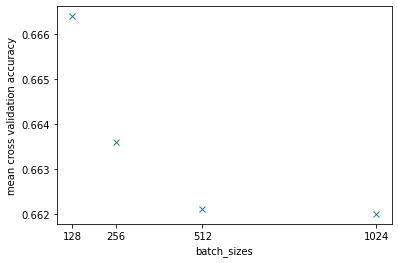

In [14]:
plt.figure(1)
plt.plot(batch_sizes, accuracy, marker = 'x', linestyle = 'None')
plt.xticks(batch_sizes)
plt.xlabel('batch_sizes')
plt.ylabel('mean cross validation accuracy')
# plt.savefig('./figures/PartA_Q2.png')

## b) Create a table of time taken to train the network on the last epoch against different batch sizes. (Hint: Introduce a callback)

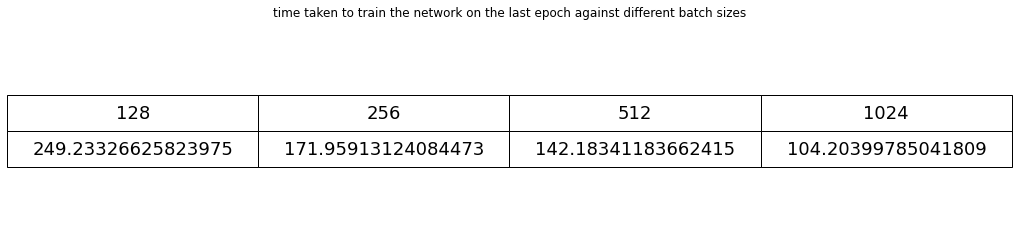

In [15]:
fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')
ax.set_title('time taken to train the network on the last epoch against different batch sizes')
df = pd.DataFrame([last_epoch_times], columns=batch_sizes)

table = ax.table(cellText=df.values, colLabels=df.columns, loc='center')
table.scale(3, 3)
table.set_fontsize(20)

plt.show()

## c) Select the optimal batch size and state a reason for your selection.

The optimum batch size selected is 128 as it has the highest cross validation accuracy. Although it takes longer to train an epoch with batch_size 128, its improvement in accuracy is large enough to offset the difference in training time

## d) What happens when batch size increases, and why does it happen?

* As batch size increases, the cross validation accuracy decreases, This is because the cost function of a mini-batch descent model requires all individual cost function of all individual patterns in the batch to be summed and meaned, this will then decide the extent of gradient to be moved. Thus, some important weights are lost in the summation and mean process as compared to a SGD
* As the batch size increases the time taken to train the model also decreases,this is because the cost function that calculates cost at each epoch includes more patterns

## e) Plot the train and test accuracies against epochs for the optimal batch size in a line plot.

In [16]:
total_data = X_train_scaled.shape[0]
no_epochs = 100
no_neurons_hidden = 128
lr = 0.001
dropout_prob = 0.2
batch_size = 128

weight_path = './data/models/PartA_Q2/2e/optimmum_weights'

optimum_model = build_model((X_train_scaled.shape[1],),no_neurons_hidden)
optimum_history,timecallbackinstance = compile_and_train(optimum_model,
                            no_epochs,
                            lr,
                            batch_size,
                            X_train_scaled,
                            y_train,
                            X_test_scaled,
                            y_test,
                            weight_path)

Epoch 1/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6903 - accuracy: 0.5348 - mean_squared_error: 0.2547 - val_loss: 0.6845 - val_accuracy: 0.5495 - val_mean_squared_error: 0.2523
Epoch 2/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6839 - accuracy: 0.5500 - mean_squared_error: 0.2552 - val_loss: 0.6833 - val_accuracy: 0.5527 - val_mean_squared_error: 0.2553
Epoch 3/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6809 - accuracy: 0.5590 - mean_squared_error: 0.2564 - val_loss: 0.6812 - val_accuracy: 0.5578 - val_mean_squared_error: 0.2535
Epoch 4/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6776 - accuracy: 0.5642 - mean_squared_error: 0.2579 - val_loss: 0.6782 - val_accuracy: 0.5622 - val_mean_squared_error: 0.2547
Epoch 5/100
997/997 [==============================] - 4s 4ms/step - loss: 0.6742 - accuracy: 0.5694 - mean_squared_error: 0.2595 - val_loss: 0.6752 - val_accuracy: 0.5696 - val_me

Epoch 41/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5957 - accuracy: 0.6670 - mean_squared_error: 0.2940 - val_loss: 0.6079 - val_accuracy: 0.6572 - val_mean_squared_error: 0.2802
Epoch 42/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5946 - accuracy: 0.6678 - mean_squared_error: 0.2947 - val_loss: 0.6096 - val_accuracy: 0.6605 - val_mean_squared_error: 0.2772
Epoch 43/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5946 - accuracy: 0.6680 - mean_squared_error: 0.2945 - val_loss: 0.6068 - val_accuracy: 0.6565 - val_mean_squared_error: 0.2806
Epoch 44/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5919 - accuracy: 0.6709 - mean_squared_error: 0.2958 - val_loss: 0.6066 - val_accuracy: 0.6584 - val_mean_squared_error: 0.2813
Epoch 45/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5924 - accuracy: 0.6695 - mean_squared_error: 0.2956 - val_loss: 0.6071 - val_accuracy: 0.6581 - v

Epoch 81/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5719 - accuracy: 0.6899 - mean_squared_error: 0.3044 - val_loss: 0.5933 - val_accuracy: 0.6714 - val_mean_squared_error: 0.2866
Epoch 82/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5722 - accuracy: 0.6894 - mean_squared_error: 0.3040 - val_loss: 0.5917 - val_accuracy: 0.6717 - val_mean_squared_error: 0.2876
Epoch 83/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5711 - accuracy: 0.6903 - mean_squared_error: 0.3046 - val_loss: 0.5920 - val_accuracy: 0.6721 - val_mean_squared_error: 0.2880
Epoch 84/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5707 - accuracy: 0.6900 - mean_squared_error: 0.3049 - val_loss: 0.5948 - val_accuracy: 0.6704 - val_mean_squared_error: 0.2834
Epoch 85/100
997/997 [==============================] - 4s 4ms/step - loss: 0.5709 - accuracy: 0.6906 - mean_squared_error: 0.3045 - val_loss: 0.5922 - val_accuracy: 0.6715 - v

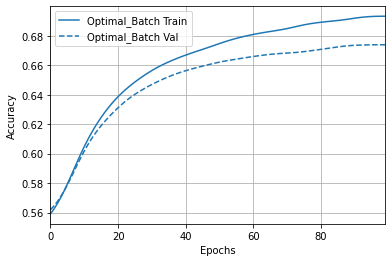

In [18]:
import tensorflow_docs.plots
# finding the mean test accuracies an train accuracies for batch size 128
optimal_batch_histories = {}
optimal_batch_histories['optimal_batch']= optimum_history

# plot the graph
plotter = tfdocs.plots.HistoryPlotter(metric = 'accuracy', smoothing_std=10)
plotter.plot(optimal_batch_histories)